In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.datasets import make_classification
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from IPython import display
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from collections import defaultdict

import sklearn.datasets

torch.manual_seed(1)
np.random.seed(7)
sns.set(style="white", palette="muted", color_codes=True, context="talk")

%matplotlib inline
print(torch.__version__) 

1.9.1.post3


In [889]:
n_classes = 2

X, y = sklearn.datasets.make_classification(n_samples=1000,
                                            n_features=5,
                                            n_informative=5,
                                            n_redundant=0,
                                            n_repeated=0,
                                            class_sep=.5,
                                            n_classes=n_classes,
                                            random_state = 4)

n_features = X.shape[1]

In [890]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=7)
print('len train:', len(X_train))
print('len test:', len(X_test))

len train: 800
len test: 200


In [891]:
BATCH_SIZE = 128

training_dataset = TensorDataset(torch.from_numpy(X_train).float(), 
                                 torch.from_numpy(y_train).long())
train_loader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

testing_dataset = TensorDataset(torch.from_numpy(X_test).float(), 
                                torch.from_numpy(y_test).long())
test_loader = DataLoader(testing_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [892]:
class Classifier(nn.Module):
    def __init__(self, n_features, n_hidden=6):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
#            nn.ReLU(),
#            nn.Linear(n_hidden, n_hidden),
#            nn.ReLU(),
#            nn.Linear(n_hidden, n_hidden),
#            nn.ReLU(),
#            nn.Linear(n_hidden, n_hidden),
#            nn.ReLU(),
#            nn.Linear(n_hidden, n_classes),
            nn.LogSoftmax()
        )

    def forward(self, x):
        return self.network(x)

In [973]:
class Classifier(nn.Module):
    def __init__(self, n_features, n_hidden=6):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_classes),
            nn.LogSoftmax()
        )

    def forward(self, x):
        return self.network(x)

In [974]:
def accuracy(model, X, y):
    Xt = torch.from_numpy(X).float()
    yt = torch.from_numpy(y).long()
    outputs = model(Xt)
    values, indices = outputs.max(dim=1)
    y_hat = indices.detach().numpy()
    accuracy = np.sum(y_hat == y) / len(y)
    return accuracy

In [975]:
import autograd_hacks
import immediate_sensitivity_primitives as isp

In [976]:
def get_eps(epsilon, alpha, delta):
    ed_eps = epsilon + np.log(1/delta)/(alpha - 1)
    print(f'Total epsilon = {ed_eps}, delta = {delta}')
    return ed_eps

In [977]:
get_eps(0.036, 50000, 1e-5)

Total epsilon = 0.03623026311456169, delta = 1e-05


0.03623026311456169

In [978]:
def compute_grad_median(model, C):
    for param in model.parameters():
        median_grad = param.grad1.data.median(axis=0).values
        param.grad = median_grad
    return 0


In [979]:
def compute_grad_trimmed_mean(model, C):
    for param in model.parameters():
        agg_grad = param.grad1.data.clamp(min=-.1, max=.1).mean(axis=0)
        param.grad = agg_grad
    return 0


In [1584]:
def compute_sens(xs, n, m, a, b):
    def get(i):
        if i < 0:
            return a
        elif i >= n:
            return b
        else:
            return xs[i]
    
    # calculate the smooth sensitivity
    t = 5
    scaled_sensitivity_at_distances = []

    #for k in range(0, n+1):
    for k in range(0, 3): # TODO: loop over k (but this is slow)
        scaling = np.exp(- k * t)
        
        indices = [(n-m+1+k-l, m+1-l) for l in range(0, k+1)]
        inner = torch.tensor([get(n-m+1+k-l) - get(m+1-l) for l in range(0, k+2)])
        inner_max = inner.max()
        scaled_inner = scaling * inner_max
        #print('k:', k, 'scaled sens:', scaled_inner)
        scaled_sensitivity_at_distances.append(scaled_inner)

    return (1/(n - 2*m)) * np.max(scaled_sensitivity_at_distances)

In [1585]:
def compute_grad_trimmed_mean(model, C):
    sensitivities = []
    clip_lower = -10
    clip_upper = 10
    for param in model.parameters():
        clipped_grads = param.grad1.data.clamp(min=clip_lower, max=clip_upper)
        sorted_grad = clipped_grads.sort(axis=0).values
        
        # calculate m
        n = BATCH_SIZE
        #m = int((2*n - n) / 4) # define m to include 50% of the data
        #m = int((4*n - n) / 8) # define m to include 25% of the data
        #m = int((9/20)*n)
        m = 50
        
        # aggregate the gradients (perform the trimmed mean)
        trimmed_grads = sorted_grad[m+1:n-m]
        agg_grad = trimmed_grads.mean(axis=0)
        agg_grad = clipped_grads.mean(axis=0)
        param.grad = agg_grad
        
        #print('sorted grad shape:', sorted_grad.shape)
        #print(sorted_grad[:,0,0].shape)
        #print(sorted_grad)
        
        reshaped = sorted_grad.reshape((n, -1))
        bs, w = reshaped.shape
        
        for i in range(w):
            sensitivities.append(compute_sens(reshaped[:, i], n, m, clip_lower, clip_upper))
        
    #print(sensitivities)
    return sensitivities

In [1586]:
def run_experiment(epsilon, epochs, add_noise=False):
    # reset the model
    model = Classifier(n_features=n_features)
    model_criterion = nn.NLLLoss() 
    model_optimizer = optim.Adam(model.parameters(),lr=0.1)
    autograd_hacks.add_hooks(model)

    info = {
        'sensitivities': [],
        'epsilons': [],
        'total_epsilon': []
    }

    sigma_sq = 0.1
    t = 5
    alpha = 5000
    gamma = alpha*(np.exp(t) - 1) + 1
    epsilon_iter = epsilon / epochs

    def compute_eps_bar(sens):
        return alpha * ((sens**2 / (2*gamma*sigma_sq)) + (t**2 / (4*gamma**2)))
    
    def compute_sigma_sq(sens):
        top = (alpha * (sens**2)) / (2*gamma)
        bottom = epsilon_iter - ((alpha * (t**2))/(4*(gamma**2)))
        return np.exp(t) * (top / bottom)
    #return ((alpha * sens**2) / (2*gamma)) * (((4*(gamma**2))/(alpha*(t**2))) - (1/epsilon_iter))

    total_epsilon = 0
    for epoch in range(epochs):
        epoch_epsilons = []
        for x_batch_train, y_batch_train in train_loader:
            model_optimizer.zero_grad()
            inp = Variable(x_batch_train, requires_grad=True)
            outputs = model.forward(inp)
            loss = model_criterion(outputs, y_batch_train)
            loss.backward()
            autograd_hacks.compute_grad1(model)
            sensitivities = compute_grad_trimmed_mean(model, None)
            batch_sens = np.linalg.norm(sensitivities, ord=2)

            info['sensitivities'].append(batch_sens)

            autograd_hacks.clear_backprops(model)

            eps_iter = compute_eps_bar(batch_sens)
            epoch_epsilons.append(eps_iter)
            info['epsilons'].append(eps_iter)
            
            if add_noise:
                #sigma_sq = np.sqrt(((batch_sens)**2 * alpha) / (2 * epsilon_iter))
                sigma_sq = compute_sigma_sq(batch_sens)
                sigma = np.sqrt(sigma_sq)
                #print(sigma)
                with torch.no_grad():
                    for p in model.parameters():
                        p.grad += (sigma * torch.randn(p.shape).float())

            model_optimizer.step()

        #print(epoch_epsilons)
        total_epsilon = total_epsilon + np.max(epoch_epsilons)
        info['total_epsilon'].append(total_epsilon)
        #print(total_epsilon)

    if False:
        plt.plot(info['sensitivities'])
        plt.title('Smooth Sensitivity, by Iteration')
        plt.show()
        plt.plot(info['epsilons'])
        plt.title('Epsilon, by Iteration')
        plt.show()
        plt.plot(info['total_epsilon'])
        plt.title('Total Epsilon, by Epoch')
        print(info['total_epsilon'])
        plt.show()
    return model

In [1587]:
epsilon = 0.01
model = run_experiment(epsilon, 20, True)
accuracy(model, X_test, y_test)

0.66

In [1588]:
accs = [accuracy(run_experiment(epsilon, 20, True), X_test, y_test) for _ in range(10)]
print('mean:', np.mean(accs))
print('std:', np.std(accs))

mean: 0.8165000000000001
std: 0.043534469102080475


In [1360]:
get_eps(0.01, 500, 1e-5)

Total epsilon = 0.033071994919780016, delta = 1e-05


0.033071994919780016

In [1515]:
def simulate_sigma(t):
    alpha = 5000
    sens = 0.1
    epsilon_iter = 0.0001
    gamma = alpha*(np.exp(t) - 1) + 1
    #gamma = alpha*(np.exp(-t) - 1) + 1
    top = (alpha * (sens**2)) / (2*gamma)
    bottom = epsilon_iter - ((alpha * (t**2))/(4*(gamma**2)))
    return np.exp(t) * (top / bottom)

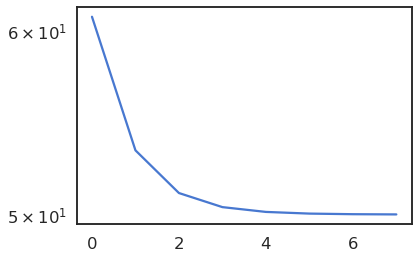

In [1516]:
plt.plot([simulate_sigma(t) for t in range(2,10)])
plt.yscale('log')

In [1519]:
def simulate_epsilon(t):
    alpha = 5000
    sens = 0.1
    sigma_sq = np.exp(t) * 0.1
    epsilon_iter = 0.0001
    gamma = alpha*(np.exp(t) - 1) + 1
    #gamma = alpha*(1 - np.exp(-t)) + 1
    lhs = (sens**2) / (2*gamma*(sigma_sq))
    rhs = (t**2) / (4*(gamma**2))
    return alpha * (lhs + rhs)

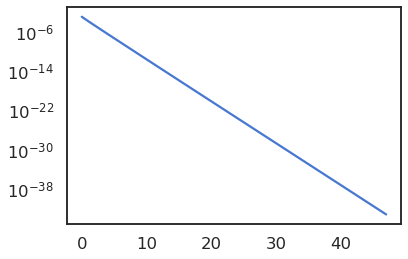

In [1522]:
plt.plot([simulate_epsilon(t) for t in range(2, 50)])
plt.yscale('log')

In [775]:
def convert_tcdp(rho, omega, delta):
    if np.log(1/delta) <= rho*(omega - 1)**2:
        print('case 1')
        return rho + 2*np.sqrt(rho*np.log(1/delta))
    else:
        print('case 2')
        return rho*omega + np.log(1/delta) / (omega - 1)

In [740]:
convert_tcdp(1.08*5, 10, 1e-5)

case 1


21.169565309270794

In [724]:
1/(1-np.exp(-.1))

10.508331944775044

In [91]:
def one_experiment(epsilon):
    model = run_experiment(epsilon, 10, True)
    return accuracy(model, X_test, y_test)

In [73]:
def run_experiments():
    epsilons = [0.01, 0.1, 1.0, 10.0, 100.0]
    runs = 10
    alpha = 200
    results = {}
    
    for eps in epsilons:
        ed_eps = get_eps(eps, 200, 1e-5)
        results[ed_eps] = [one_experiment(eps) for _ in range(runs)]
    
    return results

In [74]:
all_results = run_experiments()

Total epsilon = 0.06785389680889561, delta = 1e-05
Total epsilon = 0.1578538968088956, delta = 1e-05
Total epsilon = 1.0578538968088955, delta = 1e-05
Total epsilon = 10.057853896808895, delta = 1e-05
Total epsilon = 100.0578538968089, delta = 1e-05


In [75]:
setting = 'baseline'

In [77]:
print(f'{setting}_epsilons = {list(all_results.keys())}')
print(f'{setting}_means = {[np.mean(vs) for vs in all_results.values()]}')
print(f'{setting}_stds = {[np.std(vs) for vs in all_results.values()]}')

baseline_epsilons = [0.06785389680889561, 0.1578538968088956, 1.0578538968088955, 10.057853896808895, 100.0578538968089]
baseline_means = [0.472, 0.5055, 0.49400000000000005, 0.522, 0.726]
baseline_stds = [0.021000000000000005, 0.07538070044779366, 0.032, 0.0987977732542591, 0.159245094115957]
